Plotting a RectangleMesh


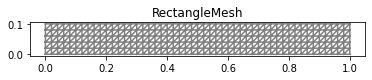

In [1]:
from dolfin import *
import numpy as np
parameters["form_compiler"]["representation"] = 'quadrature'
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)
import matplotlib.pyplot as plt

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

# Define mesh
mesh = RectangleMesh(Point(0., 0.), Point(1., 0.1), 50, 5)

print("Plotting a RectangleMesh")
plt.figure()
plot(mesh, title="RectangleMesh")

# Sub domain for clamp at left end
def left(x, on_boundary):
    return near(x[0], 0.) and on_boundary

# Sub domain for rotation at right end
def right(x, on_boundary):
    return near(x[0], 1.) and on_boundary

# Set up boundary domains

In [2]:
# Create mesh function over the cell facets
boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary_subdomains.set_all(0)
force_boundary = AutoSubDomain(right)
force_boundary.mark(boundary_subdomains, 3)

# Define measure for boundary condition integral
dss = ds(subdomain_data=boundary_subdomains)

In [3]:
E = Constant(70e3)
nu = Constant(0.3)
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu)
sig0 = Constant(2.)  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus
rho = Constant(1e5)

Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 800
load_steps = np.linspace(0, 8, Nincr+1)[1:]

dt = Constant(load_steps[1]-load_steps[0])
dt_ = float(dt)

# Newmark-beta method
betaN = Constant(0.25)
gammaN = Constant(0.5)

In [4]:
float(betaN), float(dt)

(0.25, 0.01)

In [5]:
deg_u = 2
deg_stress = 2
V = VectorFunctionSpace(mesh, "CG", deg_u)
We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W = FunctionSpace(mesh, We)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e)
# Define function space for stresses
Vsig = TensorFunctionSpace(mesh, "DG", 0)

In [6]:
sig = Function(W)
sig_old = Function(W)
n_elas = Function(W)
beta = Function(W0)
p = Function(W0, name="Cumulative plastic strain")
u = Function(V, name="Total displacement")
u_pre = Function(V)
u_old = Function(V)
u_d_old = Function(V)
u_dd_old = Function(V)
du = Function(V, name="Iteration correction")
Du = Function(V, name="Current increment")
v = TrialFunction(V)
u_ = TestFunction(V)

sig_out = Function(Vsig, name="sigma")

In [7]:
# Set up boundary condition at left end
zero = Constant((0.0, 0.0))
bc = DirichletBC(V, zero, left)
# bc = [DirichletBC(V.sub(1), 0, facets, 1), DirichletBC(V.sub(0), 0, facets, 3)]
n = FacetNormal(mesh)
q_lim = float(2/sqrt(3)*sig0)
# loading = Expression("q*t", q=q_lim, t=0, degree=2)
loading = Expression(("t <= tc ? q*t*(1-t)*4 : 0","0"), q=1*q_lim, t=0, tc=0.5, degree=2)
# p = Expression(("t <= tc ? p0*t/tc : 0", "0", "0"), t=0, tc=cutoff_Tc, p0=p0, degree=0)

def F_ext(v):
    return dot(loading,v)*dss(3)
    # return loading*dot(n, v)*dss(3)

In [8]:
# Update formula for acceleration
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
def update_a(u, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        betaN_ = betaN
    else:
        dt_ = float(dt)
        betaN_ = float(betaN)
    return (u-u_old-dt_*v_old)/betaN_/dt_**2 - (1-2*betaN_)/2/betaN_*a_old

# Update formula for velocity
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
def update_v(a, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        gamma_ = gammaN
    else:
        dt_ = float(dt)
        gamma_ = float(gammaN)
    return v_old + dt_*((1-gamma_)*a_old + gamma_*a)

def update_fields(u, u_old, v_old, a_old):
    """Update fields at the end of each time step."""

    # Get vectors (references)
    u_vec, u0_vec  = u.vector(), u_old.vector()
    v0_vec, a0_vec = v_old.vector(), a_old.vector()

    # use update functions using vector arguments
    a_vec = update_a(u_vec, u0_vec, v0_vec, a0_vec, ufl=False)
    v_vec = update_v(a_vec, u0_vec, v0_vec, a0_vec, ufl=False)

    # Update (u_old <- u)
    v_old.vector()[:], a_old.vector()[:] = v_vec, a_vec
    u_old.vector()[:] = u.vector()

In [9]:
def eps(v):
    e = sym(grad(v))
    return as_tensor([[e[0, 0], e[0, 1], 0],
                      [e[0, 1], e[1, 1], 0],
                      [0, 0, 0]])
def sigma(eps_el):
    return lmbda*tr(eps_el)*Identity(3) + 2*mu*eps_el

def sigma_out(r):
    return 2.0*mu*sym(grad(r)) + lmbda*tr(sym(grad(r)))*Identity(len(r))

def as_3D_tensor(X):
    return as_tensor([[X[0], X[3], 0],
                      [X[3], X[1], 0],
                      [0, 0, X[2]]])

In [10]:
ppos = lambda x: (x+abs(x))/2.
def proj_sig(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = dev(sig_elas)
    sig_eq = sqrt(3/2.*inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    dp = ppos(f_elas)/(3*mu+H)
    n_elas = s/sig_eq*ppos(f_elas)/f_elas
    beta = 3*mu*dp/sig_eq
    new_sig = sig_elas-beta*s
    return as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
           as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1]]), \
           beta, dp


In [11]:
def sigma_tang(e):
    N_elas = as_3D_tensor(n_elas)
    return sigma(e) - 3*mu*(3*mu/(3*mu+H)-beta)*inner(N_elas, e)*N_elas-2*mu*beta*dev(e)

In [12]:
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
dxm = dx(metadata=metadata)

# a_Newton = inner(eps(v), sigma_tang(eps(u_)))*dxm

# a_Newton = inner(eps(u_), sigma_tang(eps(v)))*dxm

a_Newton = rho*inner(u_,v)/(betaN*dt*dt)*dxm + inner(eps(u_), sigma_tang(eps(v)))*dxm

res = (-rho)*inner(u_,u)/(betaN*dt*dt)*dxm + \
      -inner(eps(u_), as_3D_tensor(sig))*dxm + \
      F_ext(u_) + \
      rho*inner(u_old+dt*u_d_old,u_)*1./(betaN*dt*dt)*dxm + \
      (1.-2*betaN)/(2*betaN)*rho*inner(u_dd_old,u_)*dxm

In [13]:
def local_project(v, V, u=None):
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dxm
    b_proj = inner(v, v_)*dxm
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [14]:
file_results = XDMFFile("plasticity_results_plas.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
P0 = FunctionSpace(mesh, "DG", 0)
p_avg = Function(P0, name="Plastic strain")

In [15]:
results = np.zeros((Nincr+1, 5))
results_1d = np.zeros((Nincr+1, 50))
for (i, t) in enumerate(load_steps):
    loading.t = t
    A, Res = assemble_system(a_Newton, res, bc)
    nRes0 = Res.norm("l2")
    nRes = nRes0
    Du.interpolate(Constant((0, 0)))
    print("Increment:", str(i+1),"   Initial Residual:", nRes0)
    niter = 0
    u_pre.assign(u)
    while (nRes/nRes0 > tol and nRes0>1e-10) and niter < Nitermax:
        solve(A, du.vector(), Res, "mumps")
        Du.assign(Du+du)
        u.assign(u+du)
        deps = eps(Du)
        sig_, n_elas_, beta_, dp_ = proj_sig(deps, sig_old, p)
        local_project(sig_, W, sig)
        local_project(n_elas_, W, n_elas)
        local_project(beta_, W0, beta)
        A, Res = assemble_system(a_Newton, res, bc)
        nRes = Res.norm("l2")
        print("    Residual:", nRes," ",niter)
        niter += 1
    u.assign(u_pre+Du)
    
    update_fields(u, u_old, u_d_old, u_dd_old)
    
    sig_old.assign(sig)
    p.assign(p+local_project(dp_, W0))
    
# ----------------
# Post-processing
# ----------------
#
# Inside the incremental loop, the displacement and plastic strains are exported
# at each time increment, the plastic strain must first be projected onto the
# previously defined DG FunctionSpace. We also monitor the value of the cylinder
# displacement on the inner boundary. The load-displacement curve is then plotted::

    local_project(sigma_out(u), Vsig, sig_out)
    
    file_results.write(u, t)
    p_avg.assign(project(p, P0))
    file_results.write(p_avg, t)
    for i_x in range(50):
        results_1d[i+1,i_x] = u(i_x/50, 0.05)[0]
    tc = 0.5;
    if t<tc:
        results[i+1, :] = (u(1, 0)[1], sig_out(1,0)[0], u(1, 0)[0],t,4*t*(1-t))
    else:
        results[i+1, :] = (u(1, 0)[1], sig_out(1,0)[0], u(1, 0)[0],t,0)


/home/aangniu/anaconda3/envs/fenicsproject/lib/python3.9/site-packages/ffc/jitcompiler.py:234: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()


Increment: 1    Initial Residual: 0.0030177713631088753
    Residual: 5.22678523593729e-17   0
Increment: 2    Initial Residual: 0.011411972940540359
    Residual: 2.3388261631788744e-16   0
Increment: 3    Initial Residual: 0.026933623458896317
    Residual: 1.6836597583120656e-16   0
Increment: 4    Initial Residual: 0.04612956462066676
    Residual: 1.2527708796776362e-16   0
Increment: 5    Initial Residual: 0.06841978382996433
    Residual: 1.1151503568144496e-16   0
Increment: 6    Initial Residual: 0.09378294405768266
    Residual: 1.1655338909764883e-16   0
Increment: 7    Initial Residual: 0.12128897025265509
    Residual: 1.1085154621698751e-16   0
Increment: 8    Initial Residual: 0.1510384170679516
    Residual: 1.1987811469161473e-16   0
Increment: 9    Initial Residual: 0.1826751734638425
    Residual: 1.247826547309176e-16   0
Increment: 10    Initial Residual: 0.21585481878775578
    Residual: 1.355002936525648e-16   0
Increment: 11    Initial Residual: 0.25036854490375

    Residual: 0.004868025900840303   0
    Residual: 0.0006307547890176825   1
    Residual: 1.0595327435897665e-08   2
Increment: 66    Initial Residual: 1.8111746098082042
    Residual: 0.002522225077756913   0
    Residual: 0.00010645063488003133   1
    Residual: 1.4077956525365391e-09   2
Increment: 67    Initial Residual: 1.8126175015262358
    Residual: 0.002701920017271325   0
    Residual: 0.00030638900881357466   1
    Residual: 8.075869706818402e-09   2
Increment: 68    Initial Residual: 1.8131627082116728
    Residual: 0.0016575114641577482   0
    Residual: 0.00014339979363956116   1
    Residual: 3.7826568762787814e-10   2
Increment: 69    Initial Residual: 1.8170491440799652
    Residual: 0.0008749330658076755   0
    Residual: 2.9620770080012722e-05   1
    Residual: 1.0232553229526838e-10   2
Increment: 70    Initial Residual: 1.8192035445848382
    Residual: 0.0048422306341139405   0
    Residual: 0.0003773765241148829   1
    Residual: 7.184187846531285e-07   2
    R

    Residual: 1.7059180671913618e-05   1
    Residual: 1.6320607296797294e-10   2
Increment: 137    Initial Residual: 1.320402103502235
    Residual: 0.0003424889675209143   0
    Residual: 8.864141313787008e-08   1
    Residual: 1.0538919115657869e-14   2
Increment: 138    Initial Residual: 1.275325554641173
    Residual: 0.001180265274590103   0
    Residual: 5.855897238288558e-05   1
    Residual: 3.380763138321695e-11   2
Increment: 139    Initial Residual: 1.228941977036837
    Residual: 0.0008275582470613373   0
    Residual: 3.560475184170954e-05   1
    Residual: 4.2848504922752897e-10   2
Increment: 140    Initial Residual: 1.1820826396492876
    Residual: 0.00030115005321964573   0
    Residual: 1.217847073102479e-07   1
    Residual: 5.1525406089875544e-14   2
Increment: 141    Initial Residual: 1.1342124569127165
    Residual: 0.0007762368529023665   0
    Residual: 0.00013075356495078263   1
    Residual: 9.244844590608383e-09   2
Increment: 142    Initial Residual: 1.0893

    Residual: 5.502486659385414e-08   1
    Residual: 5.919390007036641e-15   2
Increment: 192    Initial Residual: 1.0476703156290654
    Residual: 0.0024294763959553634   0
    Residual: 6.2671713424313444e-15   1
Increment: 193    Initial Residual: 1.0434833154462522
    Residual: 7.514047837733974e-15   0
Increment: 194    Initial Residual: 1.0340112749101895
    Residual: 7.717534855137258e-15   0
Increment: 195    Initial Residual: 1.0196897166960999
    Residual: 7.479833908886034e-15   0
Increment: 196    Initial Residual: 1.0057566074837467
    Residual: 7.945383301723637e-15   0
Increment: 197    Initial Residual: 0.9867177897984272
    Residual: 7.782278705526038e-15   0
Increment: 198    Initial Residual: 0.9698726900190231
    Residual: 7.266232200253671e-15   0
Increment: 199    Initial Residual: 0.9612144420298833
    Residual: 7.741001247936297e-15   0
Increment: 200    Initial Residual: 0.9598827495482388
    Residual: 7.530193247636327e-15   0
Increment: 201    Initia

    Residual: 4.2444062309272285e-15   0
Increment: 278    Initial Residual: 1.1788427476083772
    Residual: 4.080787848416637e-15   0
Increment: 279    Initial Residual: 1.165953027355231
    Residual: 4.642817395255798e-15   0
Increment: 280    Initial Residual: 1.149392446581843
    Residual: 4.398992340174879e-15   0
Increment: 281    Initial Residual: 1.1258679316887177
    Residual: 4.080380623692585e-15   0
Increment: 282    Initial Residual: 1.0959470085072303
    Residual: 4.039353465251168e-15   0
Increment: 283    Initial Residual: 1.060750802796682
    Residual: 4.1377469309530445e-15   0
Increment: 284    Initial Residual: 1.021916144217405
    Residual: 3.773133057624523e-15   0
Increment: 285    Initial Residual: 0.9824910689932002
    Residual: 4.049694384662486e-15   0
Increment: 286    Initial Residual: 0.9461024458329321
    Residual: 4.051101182516276e-15   0
Increment: 287    Initial Residual: 0.9124814141186225
    Residual: 3.878872792650209e-15   0
Increment: 2

    Residual: 1.310707649766753e-15   0
Increment: 368    Initial Residual: 0.8105532952476604
    Residual: 1.113686767735755e-15   0
Increment: 369    Initial Residual: 0.8033614807060478
    Residual: 1.2365864495348335e-15   0
Increment: 370    Initial Residual: 0.7981677041368366
    Residual: 1.2520970717041245e-15   0
Increment: 371    Initial Residual: 0.791287585009161
    Residual: 1.1404800845997045e-15   0
Increment: 372    Initial Residual: 0.7770741691168833
    Residual: 1.12159044355744e-15   0
Increment: 373    Initial Residual: 0.7661206254446891
    Residual: 7.703506173657517e-05   0
    Residual: 2.213210268287241e-08   1
    Residual: 2.150380507257951e-15   2
Increment: 374    Initial Residual: 0.7485205048722309
    Residual: 2.3113160894671535e-05   0
    Residual: 2.3443620188377094e-09   1
Increment: 375    Initial Residual: 0.7274881821748693
    Residual: 1.3295599578365386e-05   0
    Residual: 8.073677669984765e-10   1
Increment: 376    Initial Residual: 

    Residual: 3.274752459831088e-15   0
Increment: 441    Initial Residual: 0.91723712680892
    Residual: 3.3724208436451215e-15   0
Increment: 442    Initial Residual: 0.9230095627045477
    Residual: 3.40730509540575e-15   0
Increment: 443    Initial Residual: 0.9396821286254217
    Residual: 3.4381468914571525e-15   0
Increment: 444    Initial Residual: 0.9603621014861595
    Residual: 3.3708118450635712e-15   0
Increment: 445    Initial Residual: 0.9842711562771821
    Residual: 3.462022673470937e-15   0
Increment: 446    Initial Residual: 1.0055699998052976
    Residual: 3.5311516063053064e-15   0
Increment: 447    Initial Residual: 1.0228633599593426
    Residual: 3.644005688422424e-15   0
Increment: 448    Initial Residual: 1.035261223139506
    Residual: 3.81631689494629e-15   0
Increment: 449    Initial Residual: 1.0434789136063833
    Residual: 3.875513827849066e-15   0
Increment: 450    Initial Residual: 1.048124024402762
    Residual: 3.90459224346709e-15   0
Increment: 45

    Residual: 6.237331013054242e-15   0
Increment: 528    Initial Residual: 0.9345156706645028
    Residual: 6.303960891308657e-15   0
Increment: 529    Initial Residual: 0.9639548152338758
    Residual: 6.44506993315527e-15   0
Increment: 530    Initial Residual: 0.9938220975278862
    Residual: 6.384956064503232e-15   0
Increment: 531    Initial Residual: 1.0205037268965824
    Residual: 6.279596313071565e-15   0
Increment: 532    Initial Residual: 1.0427190528117314
    Residual: 6.520559953529784e-15   0
Increment: 533    Initial Residual: 1.0629817216467736
    Residual: 6.671150311871968e-15   0
Increment: 534    Initial Residual: 1.0755700491514506
    Residual: 6.624832143329416e-15   0
Increment: 535    Initial Residual: 1.079696490956634
    Residual: 6.338659067871156e-15   0
Increment: 536    Initial Residual: 1.0724244267839356
    Residual: 6.576703392638304e-15   0
Increment: 537    Initial Residual: 1.0580158434751907
    Residual: 6.693580385841501e-15   0
Increment: 5

    Residual: 0.0016137778721814413   0
    Residual: 8.133074624645628e-15   1
Increment: 614    Initial Residual: 0.6986196839541673
    Residual: 0.000435991949690498   0
    Residual: 2.3596035647257993e-08   1
    Residual: 6.042165390103085e-15   2
Increment: 615    Initial Residual: 0.7123605898441882
    Residual: 0.0006615015089852504   0
    Residual: 1.5478280545772302e-06   1
    Residual: 9.209414403990049e-12   2
Increment: 616    Initial Residual: 0.7208593945039617
    Residual: 9.22538726895608e-05   0
    Residual: 2.9091704903902824e-08   1
    Residual: 7.529561446245851e-15   2
Increment: 617    Initial Residual: 0.7301018828338611
    Residual: 9.893205741520053e-05   0
    Residual: 2.6555833539019213e-09   1
Increment: 618    Initial Residual: 0.7390890093983029
    Residual: 3.666095385350541e-05   0
    Residual: 2.725401326487291e-09   1
Increment: 619    Initial Residual: 0.7447164234585845
    Residual: 0.0003216048752841034   0
    Residual: 6.852711028885

    Residual: 5.33044436678182e-15   0
Increment: 700    Initial Residual: 1.0662508348636988
    Residual: 5.555619445482257e-15   0
Increment: 701    Initial Residual: 1.0812582345257162
    Residual: 5.596727492119311e-15   0
Increment: 702    Initial Residual: 1.0918201104137273
    Residual: 5.31630436420499e-15   0
Increment: 703    Initial Residual: 1.095769875766641
    Residual: 5.228451579064568e-15   0
Increment: 704    Initial Residual: 1.095002031023778
    Residual: 5.2424146860308715e-15   0
Increment: 705    Initial Residual: 1.0926081393699985
    Residual: 4.8895771312733696e-15   0
Increment: 706    Initial Residual: 1.0946988081819533
    Residual: 4.704316932919379e-15   0
Increment: 707    Initial Residual: 1.1046514728224557
    Residual: 5.0246212740727395e-15   0
Increment: 708    Initial Residual: 1.1193152949863148
    Residual: 4.9776574876726846e-15   0
Increment: 709    Initial Residual: 1.133761440705709
    Residual: 4.924727476182658e-15   0
Increment: 

    Residual: 2.5888146811269587e-15   0
Increment: 789    Initial Residual: 1.005752533705797
    Residual: 2.3200441260142193e-15   0
Increment: 790    Initial Residual: 1.0285935968516124
    Residual: 2.441098841927185e-15   0
Increment: 791    Initial Residual: 1.0432941370143918
    Residual: 2.523842193485272e-15   0
Increment: 792    Initial Residual: 1.046950366178436
    Residual: 2.240460718770284e-15   0
Increment: 793    Initial Residual: 1.0422512117353533
    Residual: 2.2631692525802143e-15   0
Increment: 794    Initial Residual: 1.0342079296609004
    Residual: 2.1629923009137096e-15   0
Increment: 795    Initial Residual: 1.0231547888349022
    Residual: 1.9827610962630457e-15   0
Increment: 796    Initial Residual: 1.0130394579252233
    Residual: 2.2431629163053165e-15   0
Increment: 797    Initial Residual: 0.9962306571740412
    Residual: 2.2023585221742064e-15   0
Increment: 798    Initial Residual: 0.9796192170787216
    Residual: 2.156984760243195e-15   0
Incre

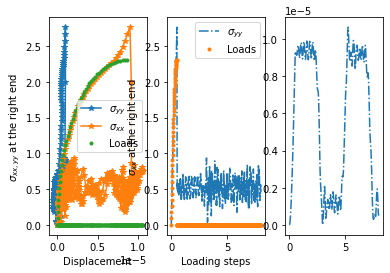

In [16]:
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.plot(results[:, 0], results[:, 1], "-*")
plt.plot(results[:, 2], results[:, 1], "-*")
plt.plot(results[:, 2], results[:, 4]*float(2/sqrt(3)*sig0), ".")
plt.xlabel("Displacement")
plt.ylabel("$\sigma_{xx,yy}$ at the right end")
plt.legend(["$\sigma_{yy}$","$\sigma_{xx}$","Loads"])
plt.subplot(1,3,2)
plt.plot(results[:, 3], results[:, 1], "-.")
plt.plot(results[:, 3], results[:, 4]*float(2/sqrt(3)*sig0), ".")
plt.xlabel("Loading steps")
plt.ylabel("$\sigma_{xx}$ at the right end")
plt.legend(["$\sigma_{yy}$","Loads"])
plt.subplot(1,3,3)
plt.plot(results[:, 3], results[:, 2], "-.")
plt.show()

In [17]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


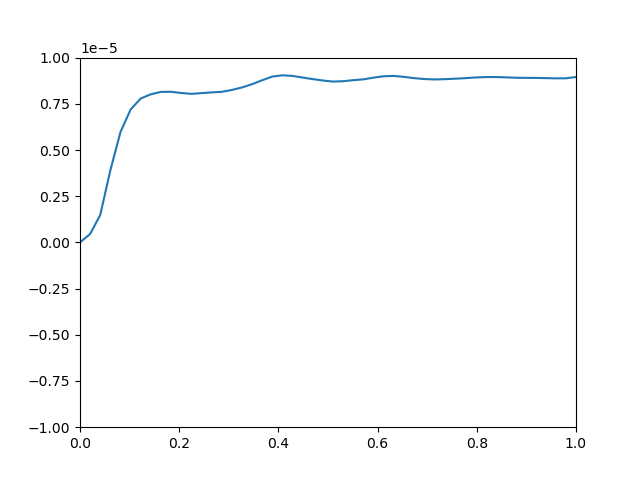

In [21]:
fig, ax = plt.subplots()

line, = ax.plot([])

ax.set_xlim(0,1)
ax.set_ylim(-1e-5,1e-5)

def animate(frame_num):
    # ax.clear()
    line.set_data((np.linspace(0,1,50), results_1d[frame_num, :]))
    return line

ani = FuncAnimation(fig, animate, frames=800, interval=50)


plt.show()
